In [31]:
%matplotlib inline

import numpy as np
import pandas as pd

import random

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and exploratory visualization

There is a minimal processing involving the raw data in order to clean, normalise, transform and extract the interesting feature form the raw data. 

### 1. Merged database

The first step is to have a unique normalized database for geographical coordinates, variables as well as gold grades. This has been possible using the Leapfrog software and exporting a merged table

In [2]:
# Read the merged table exported from Leapfrog
folder = 'data'
df = pd.read_csv(folder+'/Leapfrog_export.csv')
df = df.set_index(list(df)[3])
df.head()

,X,Y,Z,CODE_STRUCT,LITHO_DESC,AU_AVG_GT
Hole Id,,,,,,
#1,296149.710000,5331108.870000,310.7100,NaN,Casing,NaN
#1,296149.710000,5331108.870000,309.5700,NaN,Intermediate to Ultramafic Volcanics,NaN
#2,296156.177340,5331148.944062,311.5619,NaN,Intermediate to Ultramafic Volcanics,NaN
#2,296156.148082,5331148.218750,311.1428,NaN,Intermediate to Ultramafic Volcanics,0.0025
#2,296156.116164,5331147.427500,310.6856,NaN,Intermediate to Ultramafic Volcanics,0.0025


The table exported from Leapfrog contains geographical coordinates (X,Y,Z), and raw variables (CODE_STRUCT, LITHO_DESC, AU_AVG_GT)

### 2. Lithology and structural category

Then, each string variables is transformed in a categorical variable. For example, the CODE_STRUCT variable has 3 descriptions (nan,'CIS','FAI') corresponding to 3 categories (0,1,2)...

In [3]:
##Structure category: CIS (cisaillement) & FAI (faille)
struct = pd.unique(df.CODE_STRUCT.ravel()) 
struct_dict = {value: key for (key, value) in enumerate(struct)}

df['STRUCT_CAT'] = df['CODE_STRUCT'].apply(lambda x: struct_dict[x])
df['STRUCT_CAT'] = df.STRUCT_CAT.replace(0, np.nan)

... and the LITHO_DESC has 17 descriptions corresponding to 17 categories.

In [4]:
#Lithology description: 
litho = pd.unique(df.LITHO_DESC.ravel())
litho_dict = {value: key for (key, value) in enumerate(litho)}

for k,v in enumerate(litho):
    print k,v

df['LITHO_CAT'] = df['LITHO_DESC'].apply(lambda x: litho_dict[x])
df['LITHO_CAT'] = df.LITHO_CAT.replace([9,7], np.nan)
df.head()

0 Casing
1 Intermediate to Ultramafic Volcanics
2 Indifferenciated Tuffs
3 Early Diorite
4 Felsic to Intermediate Dykes
5 Shear Zone
6 Diorite
7 nan
8 Diabase
9 No Litho
10 Felsic Volcanics
11 Quartz-Tourmaline Veins
12 Porphyric Granodiorite
13 Granodiorite
14 Mafic Dykes
15 Fault
16 Early Quartz Diorite


,X,Y,Z,CODE_STRUCT,LITHO_DESC,AU_AVG_GT,STRUCT_CAT,LITHO_CAT
Hole Id,,,,,,,,
#1,296149.710000,5331108.870000,310.7100,NaN,Casing,NaN,NaN,0
#1,296149.710000,5331108.870000,309.5700,NaN,Intermediate to Ultramafic Volcanics,NaN,NaN,1
#2,296156.177340,5331148.944062,311.5619,NaN,Intermediate to Ultramafic Volcanics,NaN,NaN,1
#2,296156.148082,5331148.218750,311.1428,NaN,Intermediate to Ultramafic Volcanics,0.0025,NaN,1
#2,296156.116164,5331147.427500,310.6856,NaN,Intermediate to Ultramafic Volcanics,0.0025,NaN,1


### 3. Exploratory visualization

Once we have the normalized raw database we can start doing some exploratory statistics visualization. For this end, we first extract the data for Lamaque site as all our analysis is done on the Lamaque plug dataset.




In [5]:
#Lamaque site
limitl_x = [293500,295000]
limitl_y = [5320950,5331000]

lamaque = df[(df['X'] < limitl_x[1]) & (df['X'] > limitl_x[0])]
lamaque = lamaque[(lamaque['Y'] < limitl_y[1]) & (lamaque['Y'] > limitl_y[0])]

- Plot the relationship between AU_AVG_GT and LITHO_DESC

/Users/lorenzoperozzi/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


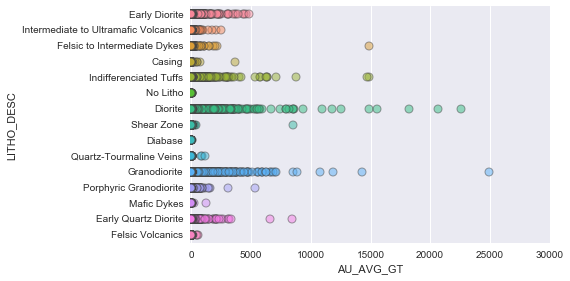

In [6]:
f, (ax) = plt.subplots(1,figsize=(8,4))            
sns.stripplot(y="LITHO_DESC", x="AU_AVG_GT", data=lamaque, jitter=False, size=8,
              edgecolor="gray", alpha=.5, ax=ax);
ax.set_xlim(-100,) 
plt.tight_layout()

- And the relationship between AU_AVG_GT and CODE_STRUCT

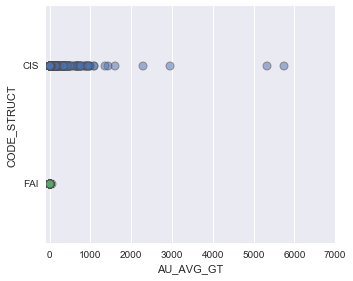

In [7]:
f, (ax) = plt.subplots(1,figsize=(5,4))            
sns.stripplot(y="CODE_STRUCT", x="AU_AVG_GT", data=lamaque, jitter=False, size=8,
              edgecolor="gray", alpha=.5, ax=ax);
ax.set_xlim(-100,) 
plt.tight_layout()
f.savefig('img/Lamaque_codeVSgld.png',dpi=300)


Starting form this two plot we can observe that there is a strong relationship between shear zone (CIS) and the gold grades as well as between Diorite, Granodiorite and gold grades.

The next step is to extract those features. For this end, I've computed the distance of each database point to the closest shear zone, as well as diorite and granodiorite lithology point using an euclidean distance approach.

### 4. Variable extraction

In [ ]:
# database coordinate extraction
points = df[['X','Y','Z']]
points = points.as_matrix()

#### DISTANCE_TO_SHEAR variable

In [ ]:
shear = df[df['CODE_STRUCT'] == 'CIS']
shear = shear[['X','Y','Z']]
shear_array = shear.as_matrix()

dist_fault = []
for c in points:
    d = euclidean_distances(c, shear_array)
    d = np.min(d)
    dist_fault.append(d)
    
df.loc[:,'DISTANCE_TO_FAULT'] = pd.Series(dist_fault, index=df.index)
df['DISTANCE_TO_FAULT'] = df['DISTANCE_TO_FAULT'].astype(float)

#### DISTANCE_TO_DIORITE variable

In [ ]:
diorite = df[df['LITHO_DESC'] == 'Diorite']
diorite = diorite[['X','Y','Z']]
diorite = diorite.as_matrix()

dist_diorite = []
for c in points:
    d = euclidean_distances(c, diorite)
    d = np.min(d)
    dist_diorite.append(d)
    

df.loc[:,'DISTANCE_TO_DIORITE'] = pd.Series(dist_diorite, index=df.index)
df['DISTANCE_TO_DIORITE'] = df['DISTANCE_TO_DIORITE'].astype(float)

#### DISTANCE_TO_GRANODIORITE variable

In [ ]:
granodiorite = df[df['LITHO_DESC'] == 'Granodiorite']
granodiorite = granodiorite[['X','Y','Z']]
granodiorite = granodiorite.as_matrix()

dist_granodiorite = []
for c in points:
    d = euclidean_distances(c, granodiorite)
    d = np.min(d)
    dist_granodiorite.append(d)
    

df.loc[:,'DISTANCE_TO_GRANODIORITE'] = pd.Series(dist_granodiorite, index=df.index)
df['DISTANCE_TO_GRANODIORITE'] = df['DISTANCE_TO_GRANODIORITE'].astype(float)

Another important feature that is worth to implement in the analysis is the distance to the gold (AU_AVG_GT) as an index to be in the mineralization.

#### DISTANCE_TO_GLD variable

In [ ]:
gold = df[df['AU_AVG_GT'] >= 5]
gold = gold[['X','Y','Z']]
gold = gold.as_matrix()

dist_gld = []
for c in points:
    d = euclidean_distances(c, gold)
    d = np.min(d)
    dist_gld.append(d)
    

df.loc[:,'DISTANCE_TO_GLD'] = pd.Series(dist_gld, index=df.index)
df['DISTANCE_TO_GLD'] = df['DISTANCE_TO_GLD'].astype(float)



The computation of those variables is very time comsuming.

### 5. AU_AVG_GT categories

The last step before obtaining the final database is to class the AU_AVG_GT variable into classes. I've choose 5 classes: very poor (< 0.1 g/t), poor (0.1-1 g/t), medium (1-5 g/t), high (5-50 g/t), very high (> 50 g/t) 

In [ ]:
# select only AU_AVG_GT that are notnull
df = df[df['AU_AVG_GT'].notnull() & df['AU_AVG_GT'] != 0]
mybins = np.array([0.0,0.1,1,5,50,26314])

# separate AU_AVG_GT into 5 classes
df['AU_CLASS'] = pd.cut(df['AU_AVG_GT'], mybins, labels=["very poor","poor","medium","rich","very rich"])

df['AU_CLASS_CAT'] = pd.cut(df['AU_AVG_GT'], mybins, labels=[1,2,3,4,5])
df['AU_CLASS_CAT'] = df['AU_CLASS_CAT'].astype(int)

In [ ]:
######  SAVING TO DISK  ########################
df.to_csv('data/lamaque_processed_categories.csv',columns=['X','Y','Z','DISTANCE_TO_FAULT','DISTANCE_TO_DIORITE','DISTANCE_TO_GRANODIORITE','DISTANCE_TO_GLD','AU_CLASS_CAT'])

### 6. Final database

The final database contain the following variables:

In [25]:
data = 'data'
lamaque = pd.read_csv(data+'/lamaque_processed_categories.csv')
lamaque.head()

,Unnamed: 0,X,Y,Z,DISTANCE_TO_FAULT,DISTANCE_TO_DIORITE,DISTANCE_TO_GRANODIORITE,DISTANCE_TO_GLD,AU_CLASS_CAT
0,0,294789.983451,5330979.09943,-88.898023,8.984796,36.649096,94.921472,27.281304,1
1,1,294788.887730,5330976.94617,-83.471563,3.045232,32.375965,93.129404,27.629878,1
2,2,294788.326035,5330975.84235,-80.689817,0.000000,30.403279,92.345437,28.247995,1
3,3,294788.016134,5330975.23335,-79.155061,1.679379,29.393345,91.953283,28.152278,1
4,4,294805.874468,5330974.53604,-89.376688,18.268291,47.392065,103.988806,11.160582,1


Starting from this databse we can now apply support learning machine to predict gold grades from x,y,z, DISTANCE_TO_FAULT, DISTANCE_TO_DIORITE, DISTANCE_TO_GRANODIORITE, DISTANCE_TO_GOLD

# SUPPORT VECTOR MACHINE analysis

For doing a proper machine learning analysis we need a set of data to train our model and a test data to predict the efficacity of the model. In data science is pretty standard to split the entire data set in 80/20. Thant means to have 80 % of the data set for training and 20% for testing. As other classifiers, SVC take as input two arrays: an array X of size  holding the training samples, and an array y of class labels.

In [26]:
rows = random.sample(lamaque.index, int(0.05*len(lamaque)))
lamaque = lamaque.ix[rows]

X = lamaque.as_matrix(columns=['X','Y','Z','DISTANCE_TO_FAULT','DISTANCE_TO_DIORITE','DISTANCE_TO_GRANODIORITE','DISTANCE_TO_GLD'])
Y = lamaque['AU_CLASS_CAT'].values.tolist()
Y = np.asarray(Y)
# Split the data set in 80/20 proportion
X_train , X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

After splitting we obtain a training data set of size:

In [27]:
print(len(X_train))

14664


and a test data set of size:

In [28]:
print(len(X_test))

3666


We train our model...

In [29]:
clf = SVC()
clf.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

And we can finally compute the accuracy score on our prediction

In [30]:
# errors on test set & sparsity
svc_error = np.sum(Y_test!=clf.predict(X_test)) / len(Y_test)
Y_pred = clf.predict(X_test)
accuracy_score = accuracy_score(Y_test, Y_pred)
svc_message = "SVC prediction error on test set for Lamaque dataset is {0}"
print svc_message.format(accuracy_score)

SVC prediction error on test set for Lamaque dataset is 0.676486633933
